In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
from read_results import read_varnames
import strato_code.kpp4py as kpp

In [3]:
nvar = 34
varnames = read_varnames("strato_code/strato_Parameters.f90")[0:nvar]
print(varnames)

['CH3', 'Cl2', 'Cl2O2', 'ClOO', 'OClO', 'BrCl', 'HOBr', 'BrONO2', 'HCO', 'CH3O', 'O1D', 'N2O5', 'HBr', 'CH3OOH', 'HNO4', 'HCl', 'H2O2', 'HOCl', 'HNO3', 'H', 'CH3O2', 'ClONO2', 'NO3', 'CH2O', 'Br', 'OH', 'Cl', 'ClO', 'O3', 'NO', 'BrO', 'O', 'HO2', 'NO2']


In [4]:
df_range = (
    pd.read_csv('strato_range.csv', index_col=0)
    .append(pd.DataFrame(np.array([[0.0, 1.0]]), 
                         columns=['min','max'], 
                         index=['SUN']
                        )
           )
)

df_range['mid'] = 0.5*(df_range['min']+df_range['max'])
df_range['span'] = df_range['max'] - df_range['min']
df_range.tail(10)

,min,max,mid,span
OH,3.791087e+01,1.655987e+07,8.279952e+06,1.655983e+07
Cl,7.667911e-01,7.642127e+05,3.821067e+05,7.642119e+05
ClO,2.236826e+07,8.342272e+07,5.289549e+07,6.105446e+07
O3,4.342945e+11,5.292275e+11,4.817610e+11,9.493304e+10
NO,1.000000e-08,8.828713e+08,4.414357e+08,8.828713e+08
BrO,1.096853e+04,9.603792e+05,4.856739e+05,9.494107e+05
O,1.000000e-08,6.590324e+08,3.295162e+08,6.590324e+08
HO2,9.779919e+02,1.166693e+07,5.833955e+06,1.166595e+07
NO2,2.134505e+08,1.066423e+09,6.399367e+08,8.529723e+08
SUN,0.000000e+00,1.000000e+00,5.000000e-01,1.000000e+00


# Make training data

In [5]:
y0_list =  np.random.uniform(df_range['min'] + 0.3*df_range['span'],
                             df_range['max'] - 0.3*df_range['span'], 
                             size=(5000, nvar+1))
y0_list.shape

(5000, 35)

In [6]:
%time y1_list = kpp.onestep(y0_list.T).T
y1_list.shape

CPU times: user 1.23 s, sys: 9.64 ms, total: 1.24 s
Wall time: 1.27 s


(5000, 34)

# Normalize data

In [7]:
normalizer = StandardScaler()
normalizer.fit(y0_list[:,0:34])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
X_train = np.append(normalizer.transform(y0_list[:,0:34]), 
                    y0_list[:,-1:], 
                    axis=1)
X_train.shape

(5000, 35)

In [9]:
Y_train = normalizer.transform(y1_list)
Y_train.std(axis=0)

array([ 0.94509081,  1.05786176,  0.53440911,  0.95839594,  0.00866735,
        0.048933  ,  1.03201397,  0.29152717,  0.87120333,  0.9527341 ,
        0.90918801,  0.86231929,  1.35470892,  1.02519304,  1.0773644 ,
        1.103894  ,  0.94645297,  0.97206993,  1.1275482 ,  0.7136726 ,
        0.97777401,  0.88676363,  0.00281179,  0.72098184,  1.08450374,
        1.0196938 ,  0.96917129,  0.99970662,  0.97416072,  1.13139032,
        0.77739827,  0.90160218,  0.78600365,  0.76446551])

# Fit ANN

In [10]:
x_torch = Variable(torch.from_numpy(X_train).type(torch.FloatTensor))
y_torch = Variable(torch.from_numpy(Y_train).type(torch.FloatTensor))

In [11]:
H1, H2 = 100, 100

model = torch.nn.Sequential(
    torch.nn.Linear(35, H1),
    torch.nn.ReLU(),
    #torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H1),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    #torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H2),
    torch.nn.Linear(H2, 34)
)

In [12]:
loss_fn = torch.nn.MSELoss()

#optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

for t in range(2000):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%200==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.data[0])

200 0.3552519679069519
400 0.04098096117377281
600 0.02281329035758972
800 0.014444774948060513
1000 0.010956447571516037
1200 0.008205012418329716
1400 0.005747959949076176
1600 0.004179331474006176
1800 0.0032499022781848907
2000 0.0026905620470643044


In [13]:
%%time 
y_pred = model(x_torch)
y_pred_numpy = y_pred.data.numpy()

CPU times: user 10.3 ms, sys: 1.04 ms, total: 11.3 ms
Wall time: 6.42 ms


In [14]:
r2_score(y_pred_numpy.ravel(), Y_train.ravel())

0.99937172135169905

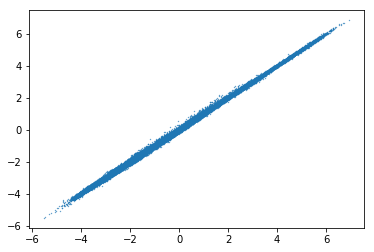

In [15]:
plt.scatter(y_pred_numpy.ravel(), Y_train.ravel(), s=0.1)

# Test set

In [16]:
y0_test = np.random.uniform(df_range['min'] + 0.3*df_range['span'],
                            df_range['max'] - 0.3*df_range['span'], 
                            size=(5000, nvar+1))
y0_list.shape

(5000, 35)

In [17]:
%time y1_test = kpp.onestep(y0_test.T).T

CPU times: user 1.31 s, sys: 30.3 ms, total: 1.34 s
Wall time: 1.37 s


In [18]:
X_test = np.append(normalizer.transform(y0_test[:,0:34]), 
                   y0_test[:,-1:], 
                   axis=1)
Y_test = normalizer.transform(y1_test)

In [19]:
%%time
X_torch_test = Variable(torch.from_numpy(X_test).type(torch.FloatTensor))
y_test_pred = model(X_torch_test).data.numpy()

CPU times: user 12.5 ms, sys: 2.94 ms, total: 15.5 ms
Wall time: 9.36 ms


In [20]:
r2_score(y_test_pred.ravel(), Y_test.ravel())

0.9992898744098877

(-4, 4)

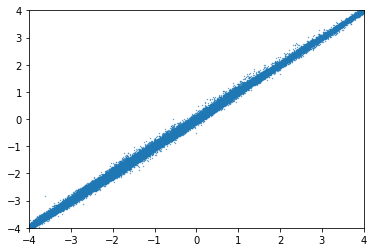

In [21]:
plt.scatter(y_test_pred, Y_test, s=0.1)
plt.xlim(-4,4)
plt.ylim(-4,4)

(-4, 4)

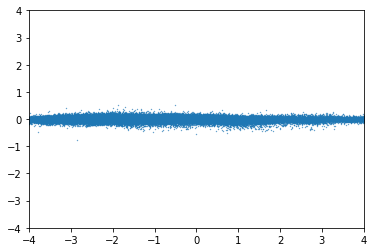

In [22]:
plt.scatter(Y_test, y_test_pred-Y_test, s=0.1)
plt.xlim(-4,4)
plt.ylim(-4,4)